<a href="https://colab.research.google.com/github/jmbaek/proteinBERT/blob/main/ProtBert_MS_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**1. Check the GPU device**


In [2]:
!nvidia-smi

Tue Mar 29 11:13:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

**2. Load necessry libraries including huggingface transformers**

In [3]:
!pip -q install transformers

     |████████████████████████████████| 3.8 MB 9.6 MB/s 
     |████████████████████████████████| 596 kB 58.9 MB/s 
     |████████████████████████████████| 6.5 MB 58.1 MB/s 
     |████████████████████████████████| 895 kB 58.8 MB/s 
     |████████████████████████████████| 67 kB 7.0 MB/s 


In [4]:
import torch
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification
from torch.utils.data import Dataset
import os
import pandas as pd
import requests
from tqdm.auto import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import re

**3. Select the model you want to fine-tune**

In [5]:
model_name = 'Rostlab/prot_bert_bfd'

**4. Create the Membrane dataset class**

In [6]:
class DeepLocDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, split="train", tokenizer_name='Rostlab/prot_bert_bfd', max_length=1024):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.datasetFolderPath = 'dataset/'
        self.trainFilePath = os.path.join(self.datasetFolderPath, 'deeploc_per_protein_train.csv')
        self.testFilePath = os.path.join(self.datasetFolderPath, 'deeploc_per_protein_test.csv')

        self.downloadDeeplocDataset()

        self.tokenizer = AutoTokenizer.from_pretrained(tokenizer_name, do_lower_case=False)

        if split=="train":
          self.seqs, self.labels = self.load_dataset(self.trainFilePath)
        else:
          self.seqs, self.labels = self.load_dataset(self.testFilePath)

        self.max_length = max_length

    def downloadDeeplocDataset(self):
        deeplocDatasetTrainUrl = 'https://www.dropbox.com/s/vgdqcl4vzqm9as0/deeploc_per_protein_train.csv?dl=1'
        deeplocDatasetValidUrl = 'https://www.dropbox.com/s/jfzuokrym7nflkp/deeploc_per_protein_test.csv?dl=1'

        if not os.path.exists(self.datasetFolderPath):
            os.makedirs(self.datasetFolderPath)

        def download_file(url, filename):
            response = requests.get(url, stream=True)
            with tqdm.wrapattr(open(filename, "wb"), "write", miniters=1,
                              total=int(response.headers.get('content-length', 0)),
                              desc=filename) as fout:
                for chunk in response.iter_content(chunk_size=4096):
                    fout.write(chunk)

        if not os.path.exists(self.trainFilePath):
            download_file(deeplocDatasetTrainUrl, self.trainFilePath)

        if not os.path.exists(self.testFilePath):
            download_file(deeplocDatasetValidUrl, self.testFilePath)

    def load_dataset(self,path):
        df = pd.read_csv(path,names=['input','loc','membrane'],skiprows=1)
        df = df.loc[df['membrane'].isin(["M","S"])]
        self.labels_dic = {0:'Soluble',
                           1:'Membrane'}

        df['labels'] = np.where(df['membrane']=='M', 1, 0)
        
        seq = list(df['input'])
        label = list(df['labels'])

        assert len(seq) == len(label)
        return seq, label

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        seq = " ".join("".join(self.seqs[idx].split()))
        seq = re.sub(r"[UZOB]", "X", seq)

        seq_ids = self.tokenizer(seq, truncation=True, padding='max_length', max_length=self.max_length)

        sample = {key: torch.tensor(val) for key, val in seq_ids.items()}
        sample['labels'] = torch.tensor(self.labels[idx])

        return sample

**4a. Create the train / val / test datasets**

In [8]:
train_dataset = DeepLocDataset(split="train", tokenizer_name=model_name, max_length=1024)
val_dataset = DeepLocDataset(split="valid", tokenizer_name=model_name, max_length=1024)
test_dataset = DeepLocDataset(split="test", tokenizer_name=model_name, max_length=1024)

dataset/deeploc_per_protein_train.csv:   0%|          | 0/7417223 [00:00<?, ?it/s]

dataset/deeploc_per_protein_test.csv:   0%|          | 0/2076681 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/361 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

**4b. View datasets**

In [9]:
df = pd.read_csv('dataset/deeploc_per_protein_train.csv', sep='\,')
df.shape

/usr/local/lib/python3.7/dist-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


(6622, 3)

In [10]:
df.input = df.input.str.replace(' ', '')
df['seq_Len'] = df['input'].str.len()
df.head()

,input,loc,membrane,seq_Len
0,MMKTLSSGNCTLNVPAKNSYRMVVLGASRVGKSSIVSRFLNGRFED...,Cell.membrane,M,266
1,MAKRTFSNLETFLIFLLVMMSAITVALLSLLFITSGTIENHKDLGG...,Cell.membrane,M,780
2,MGNCQAGHNLHLCLAHHPPLVCATLILLLLGLSGLGLGSFLLTHRT...,Cell.membrane,M,240
3,MDPSKQGTLNRVENSVYRTAFKLRSVQTLCQLDLMDSFLIQQVLWR...,Cell.membrane,M,653
4,MLLAWVQAFLVSNMLLAEAYGSGGCFWDNGHLYREDQTSPAPGLRC...,Cell.membrane,M,263


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 1500.0)

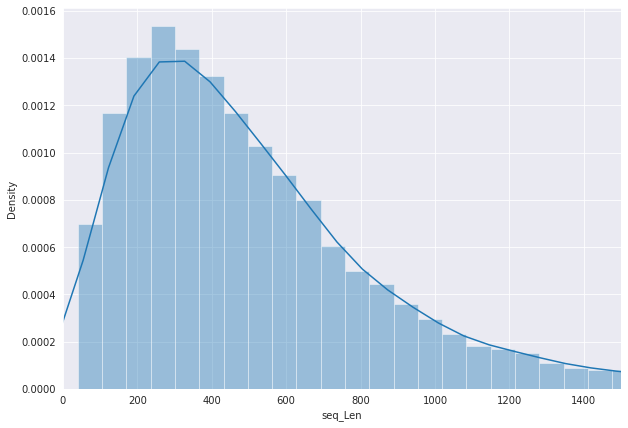

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
seq_len = df['seq_Len']

sns.set_style('darkgrid')
plt.figure(figsize=(10, 7))
sns.distplot(seq_len, bins=200).set_xlim(0,1500)

**5. Define the evaluation metrics**

In [13]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

**6. Create the model**

In [14]:
def model_init():
  return AutoModelForSequenceClassification.from_pretrained(model_name)

**7. Define the training args and start the trainer**

In [15]:
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=1,   # batch size per device during training
    per_device_eval_batch_size=32,   # batch size for evaluation
    warmup_steps=1000,               # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=200,               # How often to print logs
    do_train=True,                   # Perform training
    do_eval=True,                    # Perform evaluation
    evaluation_strategy="epoch",     # evalute after eachh epoch
    gradient_accumulation_steps=64,  # total number of steps before back propagation
    fp16=True,                       # Use mixed precision
    fp16_opt_level="02",             # mixed precision mode
    run_name="ProBert-BFD-MS",       # experiment name
    seed=3                           # Seed for experiment reproducibility 3x3
)

trainer = Trainer(
    model_init=model_init,                # the instantiated 🤗 Transformers model to be trained
    args=training_args,                   # training arguments, defined above
    train_dataset=train_dataset,          # training dataset
    eval_dataset=val_dataset,             # evaluation dataset
    compute_metrics = compute_metrics,    # evaluation metrics
)

trainer.train()

loading configuration file https://huggingface.co/Rostlab/prot_bert_bfd/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/67f460acc7e7e147ff828e909ffe419d00d66ce679c682bc4ab715c107bcbe41.baf557855a8618d0ddfb6c23bfd135bfc38ccf8c3fb099b8df45eb110ccf05e9
Model config BertConfig {
  "_name_or_path": "Rostlab/prot_bert_bfd",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 40000,
  "model_type": "bert",
  "num_attention_heads": 16,
  "num_hidden_layers": 30,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30
}

https://huggingface.co/Rostlab/prot_bert_bfd/resolve/main/pytorch_model.bin not found in ca

Downloading:   0%|          | 0.00/1.57G [00:00<?, ?B/s]

storing https://huggingface.co/Rostlab/prot_bert_bfd/resolve/main/pytorch_model.bin in cache at /root/.cache/huggingface/transformers/0a05878f9e3a0d39834dc6f21b88471696d7453a07bac7246152a6ef307c9af4.c5b9869da882baaf70e8e70cf32d81500803511e3220e24457115a03445fa65f
creating metadata file for /root/.cache/huggingface/transformers/0a05878f9e3a0d39834dc6f21b88471696d7453a07bac7246152a6ef307c9af4.c5b9869da882baaf70e8e70cf32d81500803511e3220e24457115a03445fa65f
loading weights file https://huggingface.co/Rostlab/prot_bert_bfd/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/0a05878f9e3a0d39834dc6f21b88471696d7453a07bac7246152a6ef307c9af4.c5b9869da882baaf70e8e70cf32d81500803511e3220e24457115a03445fa65f
Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias',

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,No log,0.701551,0.409384,0.580940,0.409384,1.000000
1,No log,0.435103,0.898804,0.864532,0.956403,0.788764
2,No log,0.306682,0.908004,0.881235,0.934509,0.833708


***** Running Evaluation *****
  Num examples = 1087
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1087
  Batch size = 32
***** Running Evaluation *****
  Num examples = 1087
  Batch size = 32


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=174, training_loss=0.5572485211251796, metrics={'train_runtime': 6986.9495, 'train_samples_per_second': 1.608, 'train_steps_per_second': 0.025, 'total_flos': 2.6080607615606784e+16, 'train_loss': 0.5572485211251796, 'epoch': 2.99})

**8. Save the model**

In [10]:
trainer.save_model('models/')

Saving model checkpoint to models/
Configuration saved in models/config.json
Model weights saved in models/pytorch_model.bin


**9. Check Tensorboard**

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs

**10. Make predictions**

In [17]:
predictions, label_ids, metrics = trainer.predict(test_dataset)

***** Running Prediction *****
  Num examples = 1087
  Batch size = 32


In [26]:
for idx in range (0, 20):
  sample_ground_truth = test_dataset.labels_dic[int(test_dataset[idx]['labels'])]
  sample_predictions =  test_dataset.labels_dic[np.argmax(predictions[idx], axis=0)]
  sample_sequence = test_dataset.tokenizer.decode(test_dataset[idx]['input_ids'], skip_special_tokens=True)
  print("Sequence: {} \n\tGround Truth is: {}\n\tprediction is: {}".format(sample_sequence.replace(" ", ""),
                                                                      sample_ground_truth,
                                                                      sample_predictions))

Sequence: MGLPVSWAPPALWVLGCCALLLSLWALCTACRRPEDAVAPRKRARRQRARLQGSATAAEASLLRRTHLCSLSKSDTRLHELHRGPRSSRALRPASMDLLRPHWLEVSRDITGPQAAPSAFPHQELPRALPAAAATAGCAGLEATYSNVGLAALPGVSLAASPVVAEYARVQKRKGTHRSPQEPQQGKTEVTPAAQVDVLYSRVCKPKRRDPGPTTDPLDPKGQGAILALAGDLAYQTLPLRALDVDSGPLENVYESIRELGDPAGRSSTCGAGTPPASSCPSLGRGWRPLPASLP 
	Ground Truth is: Membrane
	prediction is: Membrane
Sequence: MHSRLKFLAYLHFICASSIFWPEFSSAQQQQQTVSLTEKIPLGAIFEQGTDDVQSAFKYAMLNHNLNVSSRRFELQAYVDVINTADAFKLSRLICNQFSRGVYSMLGAVSPDSFDTLHSYSNTFQMPFVTPWFPEKVLAPSSGLLDFAISMRPDYHQAIIDTIQYYGWQSIIYLYDSHDGLLRLQQIYQELKPGNETFRVQMVKRIANVTMAIEFLHTLEDLGRFSKKRIVLDCPAEMAKEIIVQHVRDIKLGRRTYHYLLSGLVMDNHWPSDVVEFGAINITGFRIVDSNRRAVRDFHDSRKRLEPSGQSQSQNAGGPNSLPAISAQAALMYDAVFVLVEAFNRILRKKPDQFRSNHLQRRSHGGSSSSSATGTNESSALLDCNTSKGWVTPWEQGEKISRVLRKVEIDGLSGEIRFDEDGRRINYTLHVVEMSVNSTLQQVAEWRDDAGLLPLHSHNYASSSRSASASTGDYDRNHTYIVSSLLEEPYLSLKQYTYGESLVGNDRFEGYCKDLADMLAAQLGIKYEIRLVQDGNYGAENQYAPGGWDGMVGELIRKEADIAISAMTITAERERVIDFSKPFMTLGISIMIKKPVKQTPGVFSFLNPLSQEIWISVILSYVGVSFVLYFV